<a target="_blank" href="https://colab.research.google.com/github/2022-2-Graduation-Project/BowwowCare-ML/blob/main/model/dog_emotion_classification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Load Dataset

In [1]:
! pip install -q kaggle

In [ ]:
# Upload your kaggle.json
from google.colab import files

files.upload()  

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d devzohaib/dog-emotions-prediction

 99% 376M/379M [00:03<00:00, 109MB/s]
100% 379M/379M [00:03<00:00, 107MB/s]


In [7]:
ls

dog-emotions-prediction.zip  kaggle.json  sample_data/


In [8]:
!unzip dog-emotions-prediction.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: images/relaxed/7589753254_ee8544b568_b.jpg  
  inflating: images/relaxed/759543680_39c2ae5902_b.jpg  
  inflating: images/relaxed/7609431744_595047309c_b.jpg  
  inflating: images/relaxed/7613797848_52b6e2a4ac_b.jpg  
  inflating: images/relaxed/7618277504_12a9e58577_b.jpg  
  inflating: images/relaxed/7623026172_ee5fc5af84_b.jpg  
  inflating: images/relaxed/7623956526_5c55bfee35_b.jpg  
  inflating: images/relaxed/7630905134_0993274875_b.jpg  
  inflating: images/relaxed/7650586470_bab16e618f_b.jpg  
  inflating: images/relaxed/7650586740_f0a1e71f48_b.jpg  
  inflating: images/relaxed/7650587218_e8b69b8453_b.jpg  
  inflating: images/relaxed/7653104926_b172a2fc23_b.jpg  
  inflating: images/relaxed/7654628694_ca31b3633d_b.jpg  
  inflating: images/relaxed/7655545926_1288ab5e93_b.jpg  
  inflating: images/relaxed/7659667864_2b1d26a896_b.jpg  
  inflating: images/relaxed/7662075476_bc5b0b0ddf_b.jpg  
  inflating: images/relaxed/766232967

In [9]:
import os

current_folder = os.getcwd()+'/images'
print(current_folder)

/content/images


In [10]:
print('dataset size')
print('happy:', len(os.listdir(current_folder+'/happy')))
print('relaxed:', len(os.listdir(current_folder+'/relaxed')))
print('sad:', len(os.listdir(current_folder+'/sad')))
print('angry:', len(os.listdir(current_folder+'/angry')))

dataset size
happy: 4784
relaxed: 4349
sad: 4532
angry: 2256


In [11]:
positive_dir = ["happy", "relaxed"]

In [12]:
def make_content_list(dir):
  content_list = {}
  for index, val in enumerate(dir):
      path = os.path.join(current_folder, val)
      content_list[ dir[index] ] = os.listdir(path)
  return content_list

In [13]:
positive_list = make_content_list(positive_dir)

In [14]:
def make_new_folder(folder_name, parent_folder_path):
      
    # Path
    path = os.path.join(parent_folder_path, folder_name)
      
    # Create the folder
    # 'new_folder' in
    # parent_folder
    try: 
        # mode of the folder
        mode = 0o777
  
        # Create folder
        os.mkdir(path, mode) 
          
    except OSError as error: 
        print(error)

In [15]:
# folder in which all the content 
# will be merged
positive_merge_folder = "positive"

# merge_folder path - current_folder 
# + merge_folder
positive_merge_folder_path = os.path.join(current_folder, positive_merge_folder) 
  
# create merge_folder if not exists
make_new_folder(positive_merge_folder, current_folder)

In [16]:
import shutil

def merge_folder(content_list, merge_folder_path):
  # loop through the list of folders
  for sub_dir in content_list:
    # loop through the contents of the
    # list of folders
    for contents in content_list[sub_dir]:
      # make the path of the content to move
      path_to_content = sub_dir + "/" + contents
      # make the path with the current folder
      dir_to_move = os.path.join(current_folder, path_to_content)
      # move the file
      try:
        shutil.move(dir_to_move, merge_folder_path)
      except:
        pass

In [17]:
merge_folder(positive_list, positive_merge_folder_path)

In [18]:
print('positive dataset size:',len(os.listdir(current_folder+'/positive')))
print('angry dataset size:',len(os.listdir(current_folder+'/angry')))
print('sad dataset size:',len(os.listdir(current_folder+'/sad')))

positive dataset size: 9124
angry dataset size: 2256
sad dataset size: 4532


In [19]:
rm -rf './images/happy'

In [20]:
rm -rf './images/relaxed'

# Model

In [21]:
%matplotlib inline

In [22]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.4 MB/s eta 0:00:00


In [23]:
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [24]:
import timm

In [25]:
DATA_DIR = './images'

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
valid_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, test_size, valid_size])

BATCH_SIZE = 64

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True, num_workers=2)

classes = ('angry', 'positive', 'sad')

In [27]:
print(dataset_size, train_size, test_size)

15912 12729 1592


torch.Size([64, 3, 224, 224])


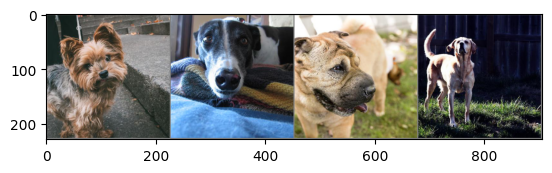

Labels: sad   sad   positive sad  


In [28]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.size())

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [29]:
BATCH_SIZE = 64
model = timm.create_model('efficientnet_b0', num_classes=3, pretrained=True)

optimizer = torch.optim.AdamW(model.parameters(),lr = 1e-3)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2, eta_min=0.001)
criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [30]:
total_step = len(trainloader)
print(total_step)
batch_valid_acc = 0
EPOCH = 3 # Decreased accuracy when epoch is greater than 3

for epoch in range(EPOCH):  # loop over the dataset multiple times
    train_acc_list = []
    running_loss = 0.0

    model.train()

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        outputs = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        preds = np.argmax(outputs,1)
        batch_acc = (preds == labels).sum() / BATCH_SIZE * 100
        train_acc_list.append(batch_acc)

    train_acc = np.mean(train_acc_list)
    print(f'Epoch [{epoch+1}/{EPOCH}], Step [{i+1}/{total_step}], Loss: {running_loss/total_step}, Acc {train_acc}')

    model.eval()
    valid_acc_list = []
    with torch.no_grad():
        correct = 0
        total = 0

        for inputs, labels in validloader:
            inputs = inputs.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor)

            outputs = model(inputs)
            valid_loss = criterion(outputs, labels)

            outputs  = outputs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            preds = np.argmax(outputs,1)
            batch_acc =  (preds == labels).sum() / BATCH_SIZE * 100
            valid_acc_list.append(batch_acc)
            
        val_acc = np.mean(valid_acc_list)
        print(f'Validation acc: {val_acc}')

    lr_scheduler.step()

PATH = './model.pth'
torch.save(model.state_dict(), PATH)

print('Finished Training')

198
Epoch [1/3], Step [198/198], Loss: 1.1491295204620169, Acc 60.25883838383838
Validation acc: 66.40625
Epoch [2/3], Step [198/198], Loss: 0.7022535882212899, Acc 70.22569444444444
Validation acc: 67.578125
Epoch [3/3], Step [198/198], Loss: 0.5558250901674984, Acc 76.83080808080808
Validation acc: 66.27604166666667
Finished Training


## Test

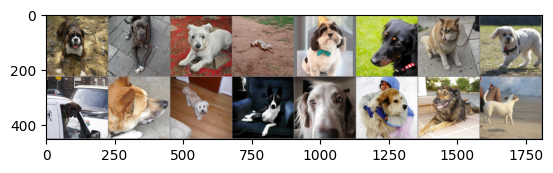

GroundTruth: 
positive sad   positive positive positive sad   sad   positive
sad   positive positive positive sad   sad   positive positive


In [31]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:16]))
print('GroundTruth: ')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8, 16)))

In [32]:
PATH = './model.pth'

In [33]:
model = timm.create_model('efficientnet_b0', num_classes=3, pretrained=True)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [34]:
outputs = model(images)

In [35]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ')
print(' '.join(f'{classes[predicted[j]]:5s}' for j in range(8)))
print(' '.join(f'{classes[predicted[j]]:5s}' for j in range(8, 16)))

Predicted: 
positive sad   positive positive positive positive sad   positive
sad   positive positive positive sad   positive positive positive


In [36]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1592 test images: {100 * correct // total} %')

Accuracy of the network on the 1592 test images: 65 %


In [37]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: angry is 14.2 %
Accuracy for class: positive is 85.1 %
Accuracy for class: sad   is 52.7 %
